In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, GATConv, GeneralConv, TransformerConv
import matplotlib.pyplot as plt


In [2]:
def load_dataset(dataset_name):
    if dataset_name == 'Chickenpox':
        speed_data = pd.read_csv('dataset/hungary_chickenpox.csv')
        adjacency_matrix = pd.read_csv('dataset/hungary_county_edges.csv').values
        edge_attr = None
        speed_data = speed_data.select_dtypes(include=[np.number])

    scaler = StandardScaler()
    speed_data = scaler.fit_transform(speed_data)
    edge_index = torch.tensor(np.stack(np.nonzero(adjacency_matrix)), dtype=torch.long)
    return speed_data, edge_index, edge_attr

In [3]:
class MLP(nn.Module):
    def __init__(self, in_channels, hidden_layers, out_channels):
        super().__init__()
        layers = []
        prev = in_channels
        for h in hidden_layers:
            layers.extend([nn.Linear(prev, h), nn.ReLU()])
            prev = h
        layers.append(nn.Linear(prev, out_channels))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

class GRUDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_gru=64):
        super().__init__()
        self.gru = nn.GRU(in_channels, hidden_gru, batch_first=True)
        self.mlp = MLP(hidden_gru, [128, 64, 32], out_channels)

    def forward(self, z):
        gru_out, _ = self.gru(z)
        return self.mlp(gru_out.squeeze(1))

class GNNModel(nn.Module):
    def __init__(self, input_size, hidden_channels, out_channels, edge_index, edge_attr=None, encoder_type='Transformer'):
        super().__init__()
        self.edge_index = edge_index
        self.edge_attr = edge_attr

        if encoder_type == 'SAGE':
            self.encoder = nn.Sequential(
                SAGEConv((-1, -1), hidden_channels),
                nn.ReLU(),
                SAGEConv((-1, -1), hidden_channels)
            )
        elif encoder_type == 'GAT':
            self.encoder = nn.Sequential(
                GATConv((-1, -1), hidden_channels, add_self_loops=False),
                nn.ReLU(),
                GATConv((-1, -1), hidden_channels, add_self_loops=False)
            )
        elif encoder_type == 'General':
            self.encoder = nn.Sequential(
                GeneralConv((-1, -1), hidden_channels),
                nn.ReLU(),
                GeneralConv((-1, -1), hidden_channels)
            )
        elif encoder_type == 'Transformer':
            edge_dim = edge_attr.size(1) if edge_attr is not None else None
            self.encoder = nn.Sequential(
                TransformerConv(input_size, hidden_channels, edge_dim=edge_dim),
                nn.ReLU(),
                TransformerConv(hidden_channels, hidden_channels, edge_dim=edge_dim)
            )
        else:
            raise ValueError(f"Unknown encoder type: {encoder_type}")

        self.decoder = GRUDecoder(hidden_channels, out_channels)

    def forward(self, x):
        if isinstance(self.encoder[0], TransformerConv):
            encoded = self.encoder[0](x, self.edge_index, self.edge_attr)
            encoded = self.encoder[1](encoded)
            encoded = self.encoder[2](encoded, self.edge_index, self.edge_attr)
        else:
            encoded = self.encoder[0](x, self.edge_index)
            encoded = self.encoder[1](encoded)
            encoded = self.encoder[2](encoded, self.edge_index)
        return self.decoder(encoded.unsqueeze(1))


In [5]:
def train_evaluate(dataset_name, encoder_type='Transformer', epochs=50, lr=0.001):
    speed_data, edge_index, edge_attr = load_dataset(dataset_name)
    input_size = speed_data.shape[1]
    tensor_data = torch.tensor(speed_data, dtype=torch.float32)
    train_size = int(len(tensor_data) * 0.8)
    train_data, test_data = tensor_data[:train_size], tensor_data[train_size:]

    model = GNNModel(
        input_size=input_size,
        hidden_channels=64,
        out_channels=input_size,
        edge_index=edge_index,
        edge_attr=edge_attr,
        encoder_type=encoder_type
    )
    optimizer = Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(train_data[:-1])
        loss = loss_fn(output, train_data[1:])
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        output = model(test_data[:-1])
        mse = mean_squared_error(test_data[1:].numpy(), output.numpy())
        mae = mean_absolute_error(test_data[1:].numpy(), output.numpy())
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((test_data[1:].numpy() - output.numpy()) / test_data[1:].numpy()))
        print(f'MSE: {mse}')
        print(f'MAE: {mae}')
        print(f'MAPE: {mape}')
        print(f'RMSE: {rmse}')

    return mse, mae, mape, rmse


In [6]:
encoder_types = ['GAT', 'SAGE', 'General', 'Transformer']
results = {}

for encoder in encoder_types:
    print(f"Encoder Type: {encoder}")
    results[encoder] = train_evaluate('Chickenpox', encoder_type=encoder)
    print("--"*20)

Encoder Type: GAT
Epoch 1/50, Loss: 1.0602
Epoch 2/50, Loss: 1.0596
Epoch 3/50, Loss: 1.0591
Epoch 4/50, Loss: 1.0586
Epoch 5/50, Loss: 1.0581
Epoch 6/50, Loss: 1.0577
Epoch 7/50, Loss: 1.0573
Epoch 8/50, Loss: 1.0569
Epoch 9/50, Loss: 1.0565
Epoch 10/50, Loss: 1.0562
Epoch 11/50, Loss: 1.0558
Epoch 12/50, Loss: 1.0554
Epoch 13/50, Loss: 1.0551
Epoch 14/50, Loss: 1.0547
Epoch 15/50, Loss: 1.0544
Epoch 16/50, Loss: 1.0541
Epoch 17/50, Loss: 1.0538
Epoch 18/50, Loss: 1.0535
Epoch 19/50, Loss: 1.0533
Epoch 20/50, Loss: 1.0531
Epoch 21/50, Loss: 1.0529
Epoch 22/50, Loss: 1.0527
Epoch 23/50, Loss: 1.0526
Epoch 24/50, Loss: 1.0524
Epoch 25/50, Loss: 1.0523
Epoch 26/50, Loss: 1.0521
Epoch 27/50, Loss: 1.0520
Epoch 28/50, Loss: 1.0518
Epoch 29/50, Loss: 1.0516
Epoch 30/50, Loss: 1.0515
Epoch 31/50, Loss: 1.0513
Epoch 32/50, Loss: 1.0511
Epoch 33/50, Loss: 1.0509
Epoch 34/50, Loss: 1.0507
Epoch 35/50, Loss: 1.0505
Epoch 36/50, Loss: 1.0503
Epoch 37/50, Loss: 1.0501
Epoch 38/50, Loss: 1.0499
Epo

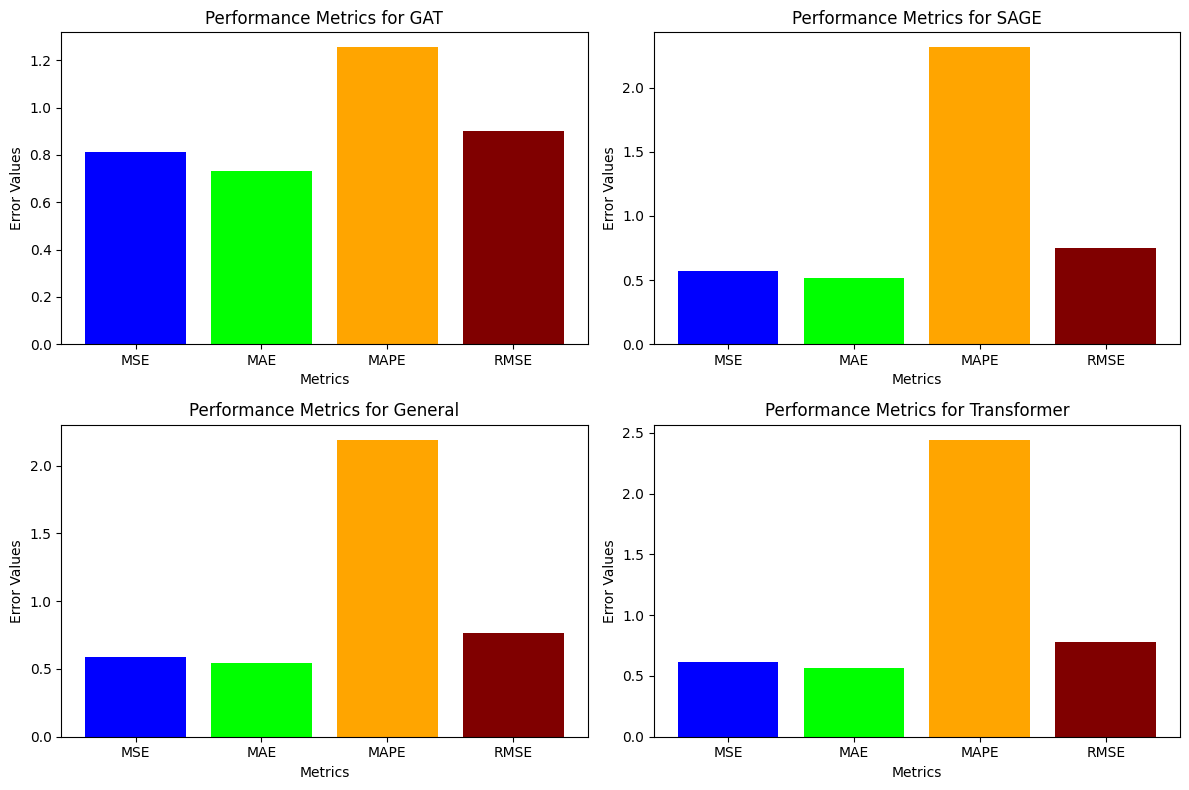

In [7]:
metrics = ['MSE', 'MAE', 'MAPE', 'RMSE']
encoder_types = list(results.keys())
values = np.array(list(results.values()))
colors = ['#0000FF', '#00FF00', '#FFA500', '#800000']  # Blue, Green, Chrome Yellow, Maroon Red

plt.figure(figsize=(12, 8))

for i, encoder in enumerate(encoder_types):
    plt.subplot(2, 2, i+1)
    plt.bar(metrics, values[i], color=colors)
    plt.title(f'Performance Metrics for {encoder}')
    plt.xlabel('Metrics')
    plt.ylabel('Error Values')

plt.tight_layout()
plt.show()